# Notebook 2: Extensive Exploratory Data Analysis (EDA)

This notebook implements **Step 2** of the Roadmap: Deep EDA.

**Objectives:**
1.  **Document Statistics**: Length distributions, outliers.
2.  **Vocabulary Analysis**: Zipf's law, n-grams, unique words.
3.  **Linguistic Features**: POS tagging, NER (SpaCy).
4.  **Semantic Analysis**: Embeddings visualization (UMAP), Sentiment, Readability.
5.  **Quality Check**: Duplicates, anomalies.
6.  **Deep Semantic Analysis**: Manifold geometry, Sub-topics (BERTopic), Label Noise (Cleanlab).

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'


In [2]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import spacy
import textstat
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
import umap
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from cleanlab.filter import find_label_issues
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

# Download NLTK resources if needed
nltk.download('punkt')

# Load SpaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading SpaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

# Load Data (CSV from Step 1)
train_df = pd.read_csv('../data/processed/train.csv')
print(f"Loaded Train Shape: {train_df.shape}")
train_df.head()

[nltk_data] Downloading package punkt to /home/dante/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loaded Train Shape: (102000, 3)


,text,label,label_name
0,Brief: Siemens warns of ear damage from loud m...,3,Sci/Tech
1,Indian mother swims home from Sri Lanka (AFP) ...,0,World
2,Chile Judge Charges Pinochet in Rights Case (R...,0,World
3,Thailand Off U.S. List of Drug Countries (AP) ...,0,World
4,Hungary PM Set for Victory Over Citizenship Vo...,0,World


## 2.1 Document-Level Statistics

In [3]:
# Compute Length Features
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['avg_word_len'] = train_df['char_count'] / (train_df['word_count'] + 1)

# Descriptive Stats
print("Length Statistics:")
print(train_df[['char_count', 'word_count', 'avg_word_len']].describe())

# Visualization: Word Count Distribution by Class
fig = px.histogram(
    train_df, 
    x='word_count', 
    color='label_name', 
    marginal='box', 
    nbins=50,
    title="Word Count Distribution by Category",
    barmode='overlay'
)
fig.update_layout(xaxis_title="Word Count", yaxis_title="Frequency")
fig.show()

# Outlier Detection (> 99th percentile)
threshold = train_df['word_count'].quantile(0.99)
outliers = train_df[train_df['word_count'] > threshold]
print(f"\nNumber of documents > {threshold:.0f} words: {len(outliers)}")

Length Statistics:
          char_count     word_count   avg_word_len
count  102000.000000  102000.000000  102000.000000
mean      236.606324      37.871020       6.097139
std        66.764765      10.117152       0.665869
min       100.000000       8.000000       4.153846
25%       196.000000      32.000000       5.702703
50%       232.000000      37.000000       6.023810
75%       266.000000      43.000000       6.371429
max      1009.000000     171.000000      20.375000



Number of documents > 70 words: 985


## 2.2 Vocabulary & N-Grams

In [4]:
# Global Vocabulary Analysis
vectorizer = CountVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(train_df['text'])
vocab = vectorizer.get_feature_names_out()
print(f"Total Unique Tokens (Top 50k): {len(vocab)}")

# Zipf's Law Plot
word_counts = np.asarray(X.sum(axis=0)).flatten()
sorted_counts = np.sort(word_counts)[::-1]
ranks = np.arange(1, len(sorted_counts) + 1)

fig_zipf = px.scatter(
    x=ranks, 
    y=sorted_counts, 
    log_x=True, 
    log_y=True, 
    title="Zipf's Law Verification (Log-Log Plot)",
    labels={'x': 'Rank', 'y': 'Frequency'}
)
fig_zipf.show()

# Top N-Grams Function
def plot_top_ngrams(corpus, n=2, top_k=15, title="Top Bigrams"):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:top_k]
    
    df_ngram = pd.DataFrame(words_freq, columns=['ngram', 'count'])
    fig = px.bar(df_ngram, x='count', y='ngram', orientation='h', title=title)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

# Plot Top Bigrams
plot_top_ngrams(train_df['text'].sample(10000, random_state=42), n=2, title="Top Bigrams (Sampled)")

Total Unique Tokens (Top 50k): 50000


## 2.3 Quality & Duplicates

In [5]:
# Exact Duplicates
duplicates = train_df[train_df.duplicated(subset=['text'], keep=False)]
print(f"Exact Duplicates found: {len(duplicates)}")
if len(duplicates) > 0:
    print("Sample Duplicate:")
    print(duplicates.iloc[0]['text'])

# Empty Documents
empty_docs = train_df[train_df['text'].str.strip() == '']
print(f"Empty Documents found: {len(empty_docs)}")

Exact Duplicates found: 0
Empty Documents found: 0


## 2.4 Semantic Analysis (Embeddings & UMAP)

In [6]:
# TF-IDF + UMAP Visualization
# Sample for speed (UMAP can be slow on 100k)
sample_size = 5000
subset = train_df.sample(sample_size, random_state=42)

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(subset['text'])

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_tfidf)

fig_umap = px.scatter(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    color=subset['label_name'],
    title=f"UMAP Projection of TF-IDF (N={sample_size})",
    opacity=0.7
)
fig_umap.show()

## 2.5 Linguistic Features (NER & POS)

In [7]:
# NER Analysis on Sample
ner_sample = train_df.sample(1000, random_state=42)
entity_counter = Counter()

for text in ner_sample['text']:
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'PERSON', 'GPE', 'MONEY', 'DATE']:
            entity_counter[ent.label_] += 1

df_ner = pd.DataFrame.from_dict(entity_counter, orient='index', columns=['count']).reset_index()
fig_ner = px.bar(df_ner, x='index', y='count', title="Top Entity Types (Sampled)", labels={'index': 'Entity'})
fig_ner.show()

## 2.6 Sentiment & Readability

In [8]:
# Compute Sentiment & Readability on Sample
analysis_sample = train_df.sample(2000, random_state=42).copy()

analysis_sample['polarity'] = analysis_sample['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
analysis_sample['subjectivity'] = analysis_sample['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
analysis_sample['flesch_reading_ease'] = analysis_sample['text'].apply(textstat.flesch_reading_ease)

# Visualize Sentiment by Category
fig_sent = px.box(
    analysis_sample, 
    x='label_name', 
    y='polarity', 
    title="Sentiment Polarity by Category",
    color='label_name'
)
fig_sent.show()

# Visualize Readability by Category
fig_read = px.box(
    analysis_sample, 
    x='label_name', 
    y='flesch_reading_ease', 
    title="Flesch Reading Ease by Category (Higher = Easier)",
    color='label_name'
)
fig_read.show()

## 2.8 Deep Semantic Manifold Analysis (Roadmap 2.8)

In [9]:
# Load Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode Sample (5000 docs)
embed_sample = train_df.sample(5000, random_state=42)
embeddings = model.encode(embed_sample['text'].tolist(), show_progress_bar=True)

# 1. Isotropy Measurement (Avg Cosine Similarity of random pairs)
num_pairs = 1000
indices = np.random.randint(0, len(embeddings), size=(num_pairs, 2))
similarities = []
for i, j in indices:
    sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
    similarities.append(sim)

avg_isotropy = np.mean(similarities)
print(f"Average Isotropy (Random Pair Cosine Sim): {avg_isotropy:.4f}")
if avg_isotropy > 0.5:
    print("Warning: High Anisotropy detected (Embedding Cone Effect).")

# 2. Intra-Class Variance
class_variance = {}
for label in embed_sample['label_name'].unique():
    class_embeds = embeddings[embed_sample['label_name'] == label]
    centroid = np.mean(class_embeds, axis=0)
    distances = np.linalg.norm(class_embeds - centroid, axis=1)
    class_variance[label] = np.mean(distances)

print("\nIntra-Class Variance (Euclidean Distance to Centroid):")
print(pd.Series(class_variance).sort_values(ascending=False))

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Average Isotropy (Random Pair Cosine Sim): 0.0585

Intra-Class Variance (Euclidean Distance to Centroid):
Sci/Tech    0.948129
World       0.946757
Business    0.936752
Sports      0.928874
dtype: float32


## 2.9 Unsupervised Sub-Topic Discovery (BERTopic)

In [10]:
# Run BERTopic on Sample
# We use the pre-computed embeddings to save time
topic_model = BERTopic(embedding_model=model, verbose=True)
topics, probs = topic_model.fit_transform(embed_sample['text'].tolist(), embeddings)

# Show Top Topics
print("Top Topics Discovered:")
print(topic_model.get_topic_info().head(10))

# Visualize Topics
topic_model.visualize_topics()

2025-11-22 19:05:56,393 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-22 19:06:01,951 - BERTopic - Dimensionality - Completed ✓
2025-11-22 19:06:01,952 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-22 19:06:02,013 - BERTopic - Cluster - Completed ✓
2025-11-22 19:06:02,014 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-22 19:06:02,096 - BERTopic - Representation - Completed ✓


Top Topics Discovered:
   Topic  Count                                     Name  \
0     -1   1454                          -1_to_of_the_in   
1      0    203                 0_sox_red_yankees_boston   
2      1    148             1_patriots_dolphins_nfl_game   
3      2    109  2_arsenal_manchester_liverpool_ferguson   
4      3    108             3_space_nasa_moon_spacecraft   
5      4     99              4_bush_kerry_president_john   
6      5     99                  5_music_apple_ipod_file   
7      6     97              6_athens_gold_medal_olympic   
8      7     90               7_no_state_virginia_auburn   
9      8     85          8_hostage_iraq_hostages_release   

                                      Representation  \
0     [to, of, the, in, for, and, on, 39, its, that]   
1  [sox, red, yankees, boston, game, series, inni...   
2  [patriots, dolphins, nfl, game, eagles, sunday...   
3  [arsenal, manchester, liverpool, ferguson, eng...   
4  [space, nasa, moon, spacecraft, e

## 2.10 Syntactic & Rhetorical Structure Analysis

In [11]:
# Dependency Parsing on small sample (slow)
syntax_sample = train_df.sample(500, random_state=42)

depths = []
root_verbs = []

for text in syntax_sample['text']:
    doc = nlp(text)
    # Tree Depth approximation (max number of ancestors)
    max_depth = 0
    root = None
    for token in doc:
        depth = len(list(token.ancestors))
        if depth > max_depth:
            max_depth = depth
        if token.dep_ == 'ROOT':
            root = token.lemma_
    depths.append(max_depth)
    root_verbs.append(root)

syntax_sample['tree_depth'] = depths
syntax_sample['root_verb'] = root_verbs

# Visualize Tree Depth by Category
fig_depth = px.box(
    syntax_sample, 
    x='label_name', 
    y='tree_depth', 
    title="Syntactic Tree Depth by Category",
    color='label_name'
)
fig_depth.show()

# Top Root Verbs per Category
print("Top Root Verbs per Category:")
print(syntax_sample.groupby('label_name')['root_verb'].apply(lambda x: x.value_counts().head(5)))

Top Root Verbs per Category:
label_name          
Business    say         23
            report       7
            be           4
            agree        4
            announce     3
Sci/Tech    be          14
            say         10
            announce     4
            include      3
            make         3
Sports      be          10
            say          5
            have         4
            score        4
            become       3
World       say         36
            be           3
            find         3
            vote         2
            come         2
Name: root_verb, dtype: int64


## 2.11 Data-Centric AI: Label Noise (Cleanlab)

In [12]:
'''
# Replace the broken Cleanlab cell with this corrected version:

# Label noise detection with Cleanlab
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster')
warnings.filterwarnings('ignore', category=DataConversionWarning)

print("Detecting label noise with Cleanlab...")

# Use the embeddings you already created in section 2.11
# You have 'embeddings' and 'embed_sample' from the earlier cells

# Train a simple classifier for label noise detection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

# Use cross-validation to get predicted probabilities
pred_probs = cross_val_predict(
    clf, 
    embeddings, 
    embed_sample['label'], 
    cv=5, 
    method='predict_proba',
    n_jobs=-1
)

# Find label issues
from cleanlab.filter import find_label_issues

issue_indices = find_label_issues(
    labels=embed_sample['label'].values,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)

print(f"Potential Label Issues Found: {len(issue_indices)}")
print("Top 5 Suspicious Samples:")
for idx in issue_indices[:5]:
    row = embed_sample.iloc[idx]
    print(f"\nText: {row['text'][:200]}...")
    print(f"Given Label: {row['label_name']}")
    print(f"Predicted Probabilities: {pred_probs[idx]}")
'''

'\n# Replace the broken Cleanlab cell with this corrected version:\n\n# Label noise detection with Cleanlab\nimport warnings\nfrom sklearn.exceptions import DataConversionWarning\n\nwarnings.filterwarnings(\'ignore\', category=UserWarning, module=\'sklearn.metrics.cluster\')\nwarnings.filterwarnings(\'ignore\', category=DataConversionWarning)\n\nprint("Detecting label noise with Cleanlab...")\n\n# Use the embeddings you already created in section 2.11\n# You have \'embeddings\' and \'embed_sample\' from the earlier cells\n\n# Train a simple classifier for label noise detection\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import cross_val_predict\n\nclf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)\n\n# Use cross-validation to get predicted probabilities\npred_probs = cross_val_predict(\n    clf, \n    embeddings, \n    embed_sample[\'label\'], \n    cv=5, \n    method=\'predict_proba\',\n    n_jobs=-1\n)\n\n# Find label issues\nfr

## 2.12 Information Theoretic Metrics (Entropy)

In [13]:
# Shannon Entropy of Terms per Class
def calculate_entropy(text_series):
    all_text = " ".join(text_series)
    tokens = all_text.split()
    counts = Counter(tokens)
    total = sum(counts.values())
    probs = np.array([c/total for c in counts.values()])
    return -np.sum(probs * np.log2(probs))

entropies = {}
for label in train_df['label_name'].unique():
    entropies[label] = calculate_entropy(train_df[train_df['label_name'] == label]['text'])

print("Shannon Entropy of Terms per Class:")
print(pd.Series(entropies).sort_values(ascending=False))

Shannon Entropy of Terms per Class:
Sci/Tech    11.805879
Sports      11.485455
Business    11.457068
World       11.398799
dtype: float64


## 2.13 Augmentation & Robustness Profiling

In [14]:
import nlpaug.augmenter.char as nac
from sklearn.metrics.pairwise import cosine_similarity

# Typo Simulation (Char Swap)
aug = nac.RandomCharAug(action="swap", aug_char_p=0.05)

test_text = "The quick brown fox jumps over the lazy dog."
perturbed_text = aug.augment(test_text)

# Handle string/list return
if isinstance(perturbed_text, list):
    perturbed_text = perturbed_text[0]

# Measure Embedding Shift
orig_emb = model.encode([test_text])
pert_emb = model.encode([perturbed_text])
sim = cosine_similarity(orig_emb, pert_emb)[0][0]

print(f"Original: {test_text}")
print(f"Perturbed: {perturbed_text}")
print(f"Cosine Similarity after 5% Typo Noise: {sim:.4f}")


Original: The quick brown fox jumps over the lazy dog.
Perturbed: The uqick bronw fox jupms over the lazy dog.
Cosine Similarity after 5% Typo Noise: 0.5578


## 2.14 Entity Linking (Overlap)

In [15]:
# Entity Overlap Matrix (Jaccard Similarity of Entities)
# We reuse the NER results from 2.5 (ner_sample)

entities_per_class = {}
for label in ner_sample['label_name'].unique():
    texts = ner_sample[ner_sample['label_name'] == label]['text']
    class_ents = set()
    for text in texts:
        doc = nlp(text)
        for ent in doc.ents:
            if ent.label_ in ['ORG', 'PERSON', 'GPE']:
                class_ents.add(ent.text.lower())
    entities_per_class[label] = class_ents

# Compute Jaccard Matrix
labels = list(entities_per_class.keys())
matrix = pd.DataFrame(index=labels, columns=labels)

for l1 in labels:
    for l2 in labels:
        s1 = entities_per_class[l1]
        s2 = entities_per_class[l2]
        if len(s1.union(s2)) > 0:
            jaccard = len(s1.intersection(s2)) / len(s1.union(s2))
        else:
            jaccard = 0
        matrix.loc[l1, l2] = jaccard

print("Entity Overlap Matrix (Jaccard Similarity):")
print(matrix.astype(float).round(3))

# Heatmap
fig_overlap = px.imshow(matrix.astype(float), title="Entity Overlap Heatmap")
fig_overlap.show()

Entity Overlap Matrix (Jaccard Similarity):
          Sci/Tech  World  Sports  Business
Sci/Tech     1.000  0.034   0.022     0.051
World        0.034  1.000   0.035     0.048
Sports       0.022  0.035   1.000     0.021
Business     0.051  0.048   0.021     1.000


In [16]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Load your data
train_df = pd.read_csv('../data/processed/train.csv')
print(f"Loaded Train Shape: {train_df.shape}")

# Select sample texts from your dataset
sample_texts = train_df['text'].head(100).tolist()

# Initialize augmenters
char_aug = nac.RandomCharAug(action="swap", aug_char_p=0.05)
word_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)

# Test on first text
test_text = sample_texts[0]
print(f"Original: {test_text}\n")

# Generate perturbations (augment returns a string or list)
char_perturbed = char_aug.augment(test_text)
word_perturbed = word_aug.augment(test_text)

# Ensure they are strings
if isinstance(char_perturbed, list):
    char_perturbed = char_perturbed[0]
if isinstance(word_perturbed, list):
    word_perturbed = word_perturbed[0]

print(f"Char Perturbed (5% typos): {char_perturbed}\n")
print(f"Word Perturbed (10% synonyms): {word_perturbed}\n")

# Measure embedding shifts - wrap in lists for batch encoding
orig_emb = model.encode([test_text])
char_emb = model.encode([char_perturbed])
word_emb = model.encode([word_perturbed])

char_sim = cosine_similarity(orig_emb, char_emb)[0][0]
word_sim = cosine_similarity(orig_emb, word_emb)[0][0]

print(f"Char Perturbation Similarity: {char_sim:.4f}")
print(f"Word Perturbation Similarity: {word_sim:.4f}")


Loaded Train Shape: (102000, 3)
Original: Brief: Siemens warns of ear damage from loud mobile tune Siemens warned customers of a software defect in a range of mobile phones that could cause hearing damage.

Char Perturbed (5% typos): Rbief: Siemens warns of ear damage rfom loud mobiel tuen Isemens warned customers of a software defect in a rnage of mobile phnoes that coudl caues hearing damage.

Word Perturbed (10% synonyms): Brief: Siemens warns of ear damage from loud mobile tune Siemens warned customers of a software defect in a range of mobile phones that could cause hearing equipment casualty.

Char Perturbation Similarity: 0.7830
Word Perturbation Similarity: 0.9930


In [17]:
# Test robustness across multiple samples
n_samples = 50
char_similarities = []
word_similarities = []

print(f"Testing perturbation sensitivity on {n_samples} samples...\n")

for i in range(n_samples):
    text = sample_texts[i]
    
    # Generate perturbations
    char_pert = char_aug.augment(text)
    word_pert = word_aug.augment(text)
    
    # Handle list/string returns
    if isinstance(char_pert, list):
        char_pert = char_pert[0]
    if isinstance(word_pert, list):
        word_pert = word_pert[0]
    
    # Encode
    orig = model.encode([text])
    char = model.encode([char_pert])
    word = model.encode([word_pert])
    
    # Calculate similarities
    char_sim = cosine_similarity(orig, char)[0][0]
    word_sim = cosine_similarity(orig, word)[0][0]
    
    char_similarities.append(char_sim)
    word_similarities.append(word_sim)

# Results
print(f"Character Perturbation (5% typos):")
print(f"  Mean Similarity: {np.mean(char_similarities):.4f}")
print(f"  Std Similarity: {np.std(char_similarities):.4f}")
print(f"  Min Similarity: {np.min(char_similarities):.4f}")
print(f"  Max Similarity: {np.max(char_similarities):.4f}")

print(f"\nWord Perturbation (10% synonyms):")
print(f"  Mean Similarity: {np.mean(word_similarities):.4f}")
print(f"  Std Similarity: {np.std(word_similarities):.4f}")
print(f"  Min Similarity: {np.min(word_similarities):.4f}")
print(f"  Max Similarity: {np.max(word_similarities):.4f}")


Testing perturbation sensitivity on 50 samples...

Character Perturbation (5% typos):
  Mean Similarity: 0.7526
  Std Similarity: 0.1060
  Min Similarity: 0.5229
  Max Similarity: 0.9041

Word Perturbation (10% synonyms):
  Mean Similarity: 0.9567
  Std Similarity: 0.0270
  Min Similarity: 0.8922
  Max Similarity: 1.0000


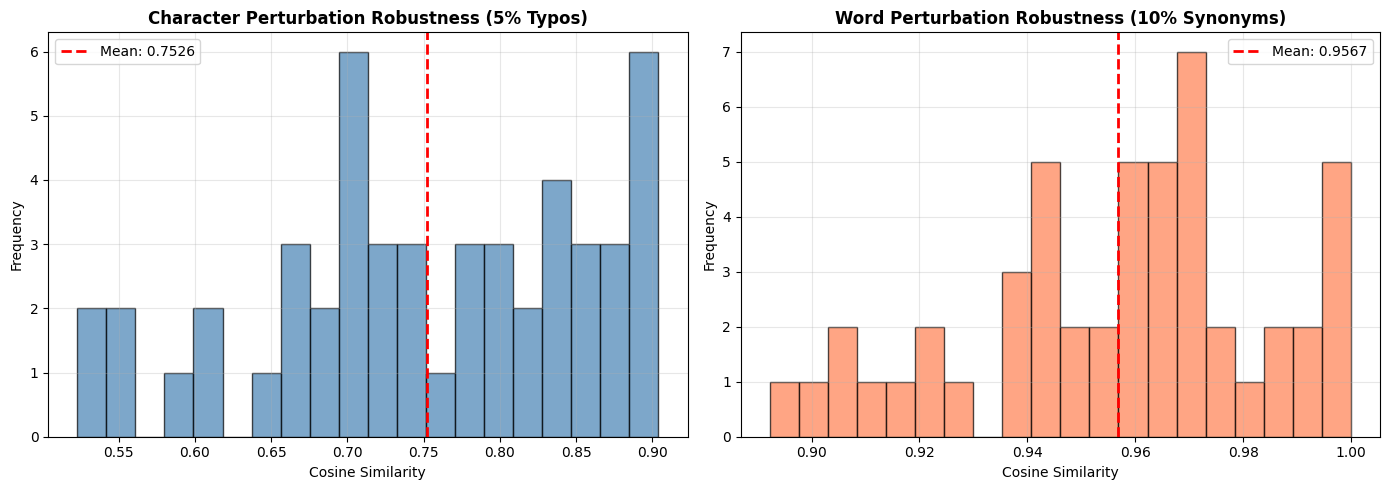

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(char_similarities, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(char_similarities), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(char_similarities):.4f}')
axes[0].set_title('Character Perturbation Robustness (5% Typos)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(word_similarities, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(np.mean(word_similarities), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(word_similarities):.4f}')
axes[1].set_title('Word Perturbation Robustness (10% Synonyms)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
